In [107]:
import os
import sys
import re
import pickle
from collections import defaultdict, OrderedDict, Counter
import warnings
warnings.filterwarnings('ignore')

import json
from tqdm import tqdm

import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix

# pd.options.display.float_format = '{:0.5f}'.format`

import matplotlib.pyplot as plt
import seaborn as sns
plt.rc('font', family='Malgun Gothic')

# settings for seaborn plot sizes
sns.set(rc={'figure.figsize':(20, 10)})

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.rc('font', family='Malgun Gothic')

# settings for seaborn plot sizes
sns.set(rc={'figure.figsize':(4.5, 3)})

In [11]:
def typeColumnSegment(df):
    numeric_columns = list(df.select_dtypes(include=['int', 'float']).columns)
    object_columns = list(df.select_dtypes(include=['object']).columns)  
    bool_columns = list(df.select_dtypes(include=['bool']).columns)
    etc_columns = list(df.select_dtypes(exclude=['int', 'float', 'bool', 'object']).columns)
    type_columns_ls = [numeric_columns, object_columns, bool_columns, etc_columns]
    strs = ['numeric', 'object', 'bool', 'etc']

    for s, type in zip(strs, type_columns_ls):
        if type:
            print(f'{s} | 칼럼 갯수 : {len(type)}')
            print(type)
            print()
    return type_columns_ls

In [12]:
df = pd.read_csv('data/소방청_구급활동현황_20181231.csv', encoding='cp949')

In [13]:
type_columns_ls = typeColumnSegment(df)
numeric_columns, object_columns, bool_columns, etc_columns = type_columns_ls

numeric | 칼럼 갯수 : 2
['집계년도', '현장과의거리']

object | 칼럼 갯수 : 29
['시군명', '출동소방서', '출동안전센터_지역대', '신고년월일', '신고시각', '접수경로', '관할구분', '출동년월일', '출동시각', '현장도착년월일', '현장도착시각', '귀소년월일', '귀소시각', '환자연령대', '환자성별', '긴급구조시', '긴급구조구', '긴급구조동', '긴급구조리', '외국인유무', '환자증상1', '환자증상2', '질병외_교통사고', '질병외_사고부상', '질병외_비외상성손상', '의식상태', '구급대원1_자격', '구급대원2_자격', '운전요원_자격']



In [14]:
for col in object_columns:
    print(f'{col} - 개수:{df[col].nunique()}')
    col_dict = df[col].value_counts(dropna=False).to_dict()
    if df[col].nunique() <50 :
        for k, v in col_dict.items():
            print('\t', k, v)

시군명 - 개수:66
출동소방서 - 개수:54
출동안전센터_지역대 - 개수:193
신고년월일 - 개수:365
신고시각 - 개수:1440
접수경로 - 개수:6
	 휴대전화 570800
	 일반전화 71021
	 기타 47239
	 공중전화 343
	 무전기 177
	 사후각지 88
	 nan 6
관할구분 - 개수:2
	 센터 548103
	 센터외 141571
출동년월일 - 개수:366
출동시각 - 개수:1440
현장도착년월일 - 개수:366
현장도착시각 - 개수:1440
귀소년월일 - 개수:369
귀소시각 - 개수:1440
환자연령대 - 개수:10
	 nan 186071
	 50대 90418
	 60대 70907
	 70대 70161
	 40대 64736
	 80대 57142
	 30대 47993
	 20대 41456
	 유아 25681
	 10대 23499
	 90대 11610
환자성별 - 개수:3
	 남 283932
	 여 228217
	 nan 177500
	 미상 25
긴급구조시 - 개수:9
	 경기도 689587
	 서울특별시 37
	 인천광역시 34
	 강원도 6
	 충청남도 2
	 충청북도 2
	 nan 2
	 대전광역시 2
	 경상남도 1
	 경상북도 1
긴급구조구 - 개수:66
긴급구조동 - 개수:742
긴급구조리 - 개수:1868
외국인유무 - 개수:2
	 N 681608
	 Y 8066
환자증상1 - 개수:43
	 nan 219870
	 기타통증 112113
	 기타 60567
	 복통 50225
	 요통 28803
	 오심/구토 28274
	 두통 25407
	 열상 22908
	 전신쇠약 20805
	 고열 17539
	 심정지 13921
	 의식장애 12079
	 호흡곤란 10153
	 흉통 9455
	 찰과상 8106
	 그 밖의출혈 7634
	 어지러움 5536
	 비출혈 4439
	 경련 4020
	 실신 3581
	 정신장애 2679
	 타박상 2243
	 골절 2147
	 배뇨장애 2098
	 편마비 1837
	 토혈 1825

In [15]:
df.columns

Index(['집계년도', '시군명', '출동소방서', '출동안전센터_지역대', '신고년월일', '신고시각', '접수경로', '관할구분',
       '출동년월일', '출동시각', '현장도착년월일', '현장도착시각', '현장과의거리', '귀소년월일', '귀소시각',
       '환자연령대', '환자성별', '긴급구조시', '긴급구조구', '긴급구조동', '긴급구조리', '외국인유무', '환자증상1',
       '환자증상2', '질병외_교통사고', '질병외_사고부상', '질병외_비외상성손상', '의식상태', '구급대원1_자격',
       '구급대원2_자격', '운전요원_자격'],
      dtype='object')

In [16]:
df = df[['신고시각', '출동년월일', '출동시각', '현장과의거리', '귀소년월일', '귀소시각', \
    '환자연령대', '환자성별', '긴급구조구', '의식상태']] 

In [17]:
df.columns

Index(['신고시각', '출동년월일', '출동시각', '현장과의거리', '귀소년월일', '귀소시각', '환자연령대', '환자성별',
       '긴급구조구', '의식상태'],
      dtype='object')

In [18]:
df.head().T

,0,1,2,3,4
신고시각,11:45,01:56,16:54,00:56,16:54
출동년월일,2018-01-02,2018-01-04,2018-01-05,2018-01-07,2018-01-05
출동시각,11:50,02:00,16:54,01:01,16:55
현장과의거리,10.0,2.5,0.8,2.7,0.4
귀소년월일,2018-01-02,2018-01-04,2018-01-05,2018-01-07,2018-01-05
귀소시각,12:26,02:07,17:02,01:03,17:06
환자연령대,NaN,NaN,NaN,NaN,NaN
환자성별,NaN,NaN,NaN,NaN,NaN
긴급구조구,남양주시,수원시 영통구,김포시,포천시,고양시 덕양구
의식상태,NaN,NaN,NaN,NaN,NaN


In [19]:
df['출동월'], df['출동일'] = df['출동년월일'].str[-5:-3], df['출동년월일'].str[-2:]
df['귀소월'], df['귀소일'] = df['귀소년월일'].str[-5:-3], df['귀소년월일'].str[-2:]
df['출동hour'], df['출동min'] = df['출동시각'].str[:2], df['출동시각'].str[-2:]
df['귀소hour'], df['귀소min'] = df['귀소시각'].str[:2], df['귀소시각'].str[-2:]
df = df[df['출동월'] == df['귀소월']]

In [20]:
df['귀소까지시간'] = df['귀소일'].astype(int)*60*24 + df['귀소hour'].astype(int)*60 + df['귀소min'].astype(int) - df['출동일'].astype(int)*60*24 - df['출동hour'].astype(int)*60 - df['출동min'].astype(int)

In [21]:
df = df[df['귀소까지시간'] > 0]

In [22]:
df.head().T

,0,1,2,3,4
신고시각,11:45,01:56,16:54,00:56,16:54
출동년월일,2018-01-02,2018-01-04,2018-01-05,2018-01-07,2018-01-05
출동시각,11:50,02:00,16:54,01:01,16:55
현장과의거리,10.0,2.5,0.8,2.7,0.4
귀소년월일,2018-01-02,2018-01-04,2018-01-05,2018-01-07,2018-01-05
...,...,...,...,...,...
출동hour,11,02,16,01,16
출동min,50,00,54,01,55
귀소hour,12,02,17,01,17
귀소min,26,07,02,03,06


In [23]:
df.columns

Index(['신고시각', '출동년월일', '출동시각', '현장과의거리', '귀소년월일', '귀소시각', '환자연령대', '환자성별',
       '긴급구조구', '의식상태', '출동월', '출동일', '귀소월', '귀소일', '출동hour', '출동min',
       '귀소hour', '귀소min', '귀소까지시간'],
      dtype='object')

In [73]:
base = df[['신고시각', '귀소까지시간', '현장과의거리', '의식상태','긴급구조구']]
# .to_csv('')

In [74]:
base.isnull().sum()

신고시각           0
귀소까지시간         0
현장과의거리         0
의식상태      201902
긴급구조구         18
dtype: int64

In [75]:
base['긴급구조구']

0            남양주시
1         수원시 영통구
2             김포시
3             포천시
4         고양시 덕양구
           ...   
689669    안산시 단원구
689670        부천시
689671       남양주시
689672        평택시
689673    용인시 처인구
Name: 긴급구조구, Length: 683534, dtype: object

In [76]:
k = base.groupby('긴급구조구')['신고시각'].count().sort_values(ascending=False).reset_index()

In [77]:
key = k['긴급구조구']
value = k['긴급구조구'].str.split().str[0][:]

In [78]:
mapping = {k:v for k, v in zip(key, value)}
mapping

{'부천시': '부천시',
 '화성시': '화성시',
 '남양주시': '남양주시',
 '평택시': '평택시',
 '의정부시': '의정부시',
 '파주시': '파주시',
 '시흥시': '시흥시',
 '고양시 덕양구': '고양시',
 '성남시 분당구': '성남시',
 '김포시': '김포시',
 '안산시 단원구': '안산시',
 '광주시': '광주시',
 '안산시 상록구': '안산시',
 '수원시 권선구': '수원시',
 '수원시 팔달구': '수원시',
 '용인시 기흥구': '용인시',
 '광명시': '광명시',
 '용인시 처인구': '용인시',
 '수원시 장안구': '수원시',
 '성남시 수정구': '성남시',
 '성남시 중원구': '성남시',
 '안양시 만안구': '안양시',
 '고양시 일산동구': '고양시',
 '안성시': '안성시',
 '양주시': '양주시',
 '이천시': '이천시',
 '군포시': '군포시',
 '포천시': '포천시',
 '안양시 동안구': '안양시',
 '용인시 수지구': '용인시',
 '수원시 영통구': '수원시',
 '하남시': '하남시',
 '오산시': '오산시',
 '고양시 일산서구': '고양시',
 '구리시': '구리시',
 '양평군': '양평군',
 '여주시': '여주시',
 '가평군': '가평군',
 '동두천시': '동두천시',
 '의왕시': '의왕시',
 '연천군': '연천군',
 '과천시': '과천시',
 '여주군': '여주군',
 '옹진군': '옹진군',
 '금천구': '금천구',
 '춘천시': '춘천시',
 '송파구': '송파구',
 '강서구': '강서구',
 '관악구': '관악구',
 '강화군': '강화군',
 '음성군': '음성군',
 '도봉구': '도봉구',
 '서초구': '서초구',
 '부천시 오정구': '부천시',
 '철원군': '철원군',
 '강남구': '강남구',
 '경기도': '경기도',
 '문경시': '문경시',
 '서구': '서구',
 '중랑구': '중랑구',
 '서산시': '서산시',
 '은평구':

In [79]:
for i, k in enumerate(mapping.keys()):
    if i >= 42:
        mapping[k] = None

In [80]:
base['긴급구조구'] = base['긴급구조구'].map(mapping)

In [81]:
base = base.dropna().reset_index()

In [82]:
base.iloc[:,1:].to_csv('업무강도관련df.csv', index=False)

In [83]:
업무강도관련df = pd.read_csv('업무강도관련df.csv')

In [84]:
업무강도관련df

,신고시각,귀소까지시간,현장과의거리,의식상태,긴급구조구
0,08:32,20,2.8,U(Coma),수원시
1,21:32,11,1.1,A(Alert),수원시
2,20:22,24,0.6,A(Alert),수원시
3,00:22,18,2.0,A(Alert),안산시
4,17:48,22,0.3,A(Alert),군포시
...,...,...,...,...,...
481521,13:12,66,1.4,P:통증.자극에 반응,안산시
481522,00:33,31,0.8,A(Alert),부천시
481523,05:20,37,4.6,P:통증.자극에 반응,남양주시
481524,00:22,68,5.4,A(Alert),평택시


<AxesSubplot:>

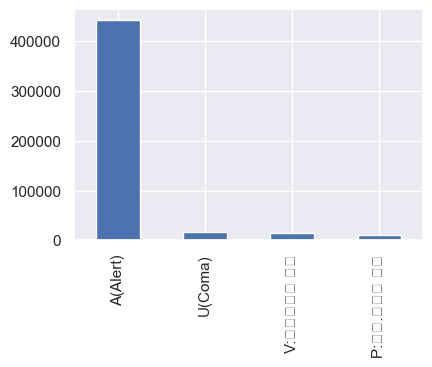

In [98]:
업무강도관련df['의식상태'].value_counts().plot.bar()

In [128]:
def map_의식상태(x):
    # A(Alert)일 경우에는 가중치
    if x == 'A(Alert)':
        return 1.2
    return 1

<AxesSubplot:>

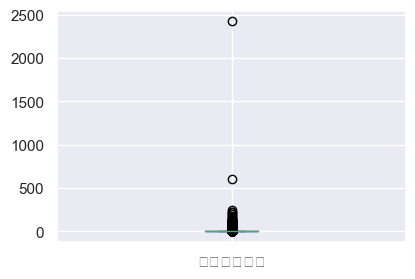

In [102]:
업무강도관련df['현장과의거리'].plot.box()

In [99]:
업무강도관련df['현장과의거리'].median()

2.0

In [100]:
def map_현장거리(x):
    # 현장과의 거리가 2.0(median) 이상 일 경우 가중치
    if x >= 2:
        return 1.2
    return 1

<AxesSubplot:>

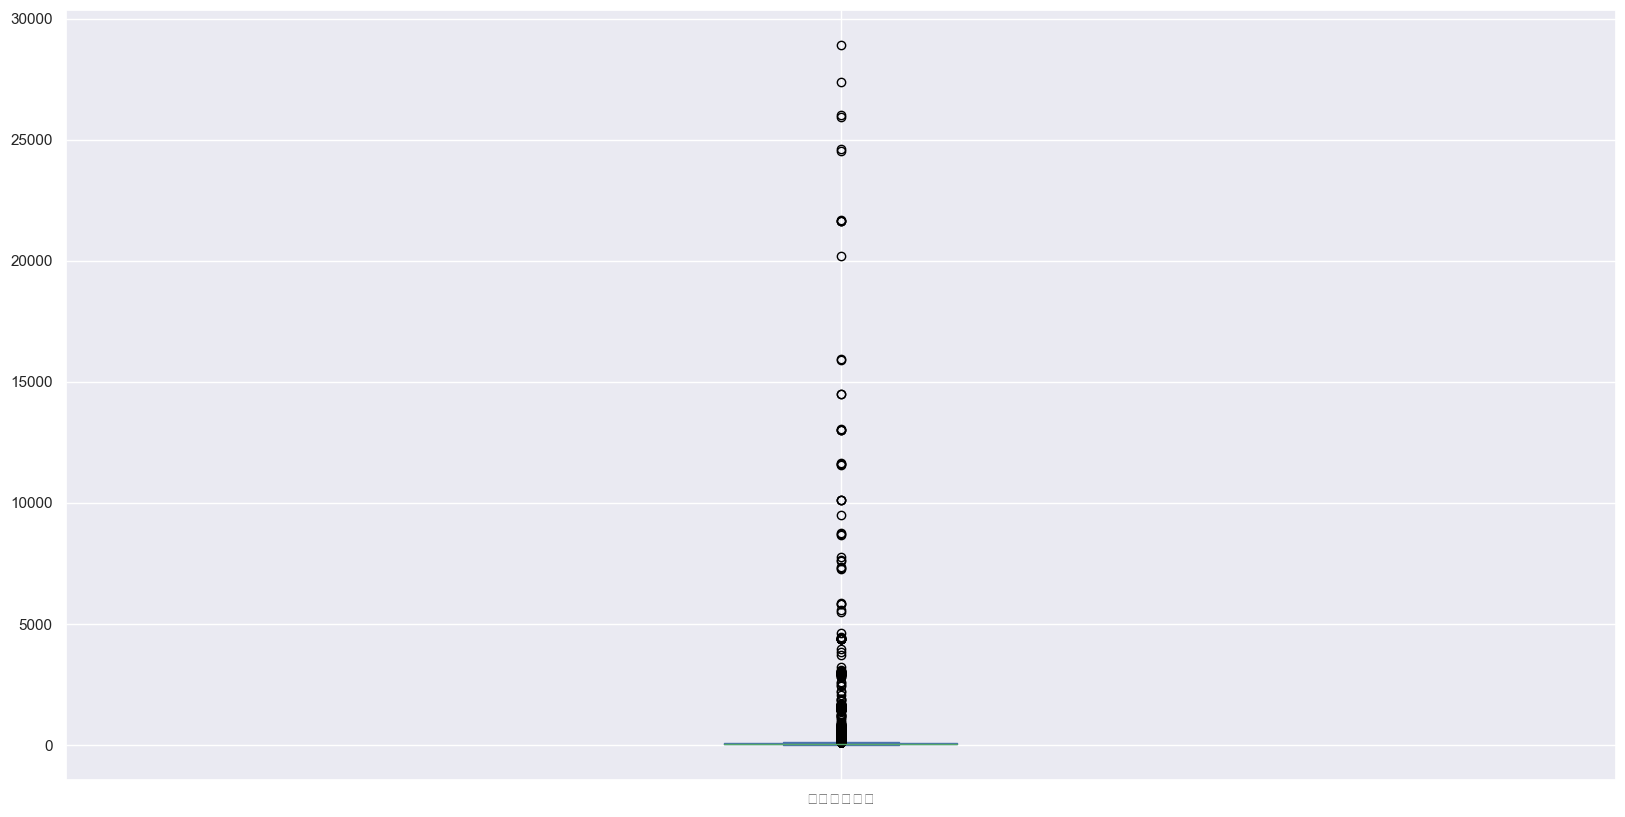

In [114]:
업무강도관련df['귀소까지시간'].plot.box()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


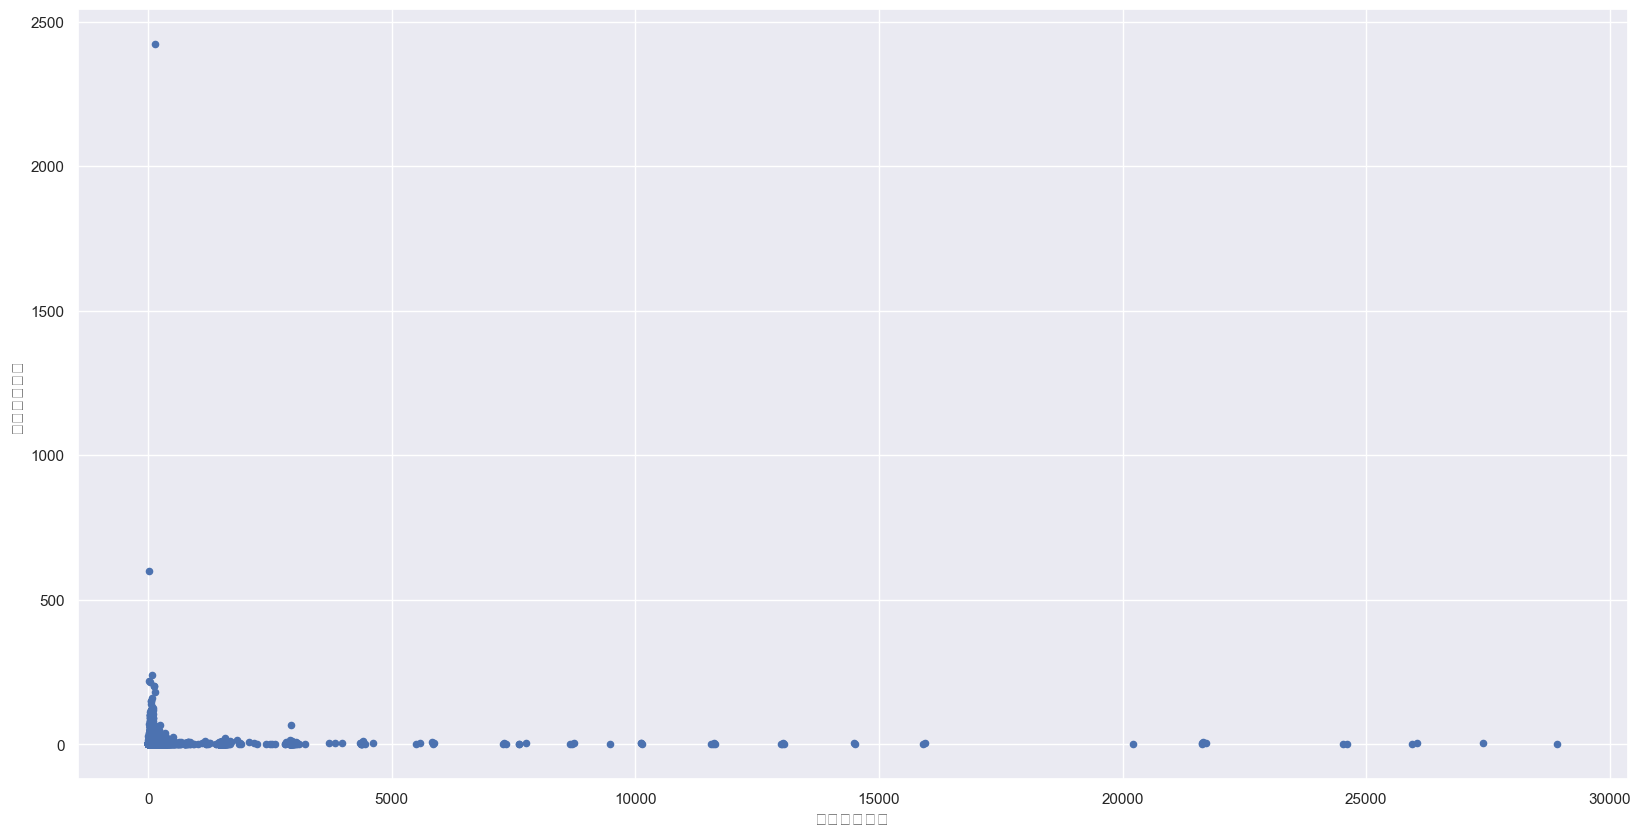

In [108]:
업무강도관련df.plot.scatter(x='귀소까지시간', y='현장과의거리');

In [127]:
업무강도관련df['귀소까지시간'].median()

45.0

In [126]:
def map_귀소걸리는시간(x):
    # 귀소까지 걸리는 시간 45.0(median) 이상 일 경우 가중치
    if x >= 45:
        return 1.2
    return 1

In [117]:
업무강도관련df['신고시각'] = 업무강도관련df['신고시각'].str[:2].astype(int)

0          8
1         21
2         20
3          0
4         17
          ..
481521    13
481522     0
481523     5
481524     0
481525    23
Name: 신고시각, Length: 481526, dtype: int32

In [118]:
def map_신고시각(x):
    # 신고 시각이 18시 이상 ~ 9시 사이 미만 일 경우 가중치
    if 9 <= x <= 17 :
        return 1
    return 1.2

In [129]:
# 업무강도관련df['신고시각'] = 업무강도관련df['신고시각'].str[:2].astype(int)
업무강도관련df['신고시각'] =업무강도관련df['신고시각'].apply(map_신고시각)
업무강도관련df['현장과의거리'] =업무강도관련df['현장과의거리'].apply(map_현장거리)
업무강도관련df['귀소까지시간'] =업무강도관련df['귀소까지시간'].apply(map_귀소걸리는시간)
업무강도관련df['의식상태'] =업무강도관련df['의식상태'].apply(map_의식상태)

In [132]:
업무강도관련df['가중치'] = 업무강도관련df['신고시각'] * 업무강도관련df['귀소까지시간'] * \
                            업무강도관련df['현장과의거리'] * 업무강도관련df['의식상태']

In [135]:
업무강도관련df['가중치'].value_counts()

1.4400    177267
1.7280    175526
2.0736     63747
1.2000     61245
1.0000      3741
Name: 가중치, dtype: int64

In [197]:
업무강도관련df

,신고시각,귀소까지시간,현장과의거리,의식상태,긴급구조구,가중치
0,1.2,1.0,1.2,1.0,수원시,1.4400
1,1.2,1.0,1.0,1.2,수원시,1.4400
2,1.2,1.0,1.0,1.2,수원시,1.4400
3,1.2,1.0,1.2,1.2,안산시,1.7280
4,1.0,1.0,1.0,1.2,군포시,1.2000
...,...,...,...,...,...,...
481521,1.0,1.2,1.0,1.0,안산시,1.2000
481522,1.2,1.0,1.0,1.2,부천시,1.4400
481523,1.2,1.0,1.2,1.0,남양주시,1.4400
481524,1.2,1.2,1.2,1.2,평택시,2.0736


<AxesSubplot:xlabel='긴급구조구'>

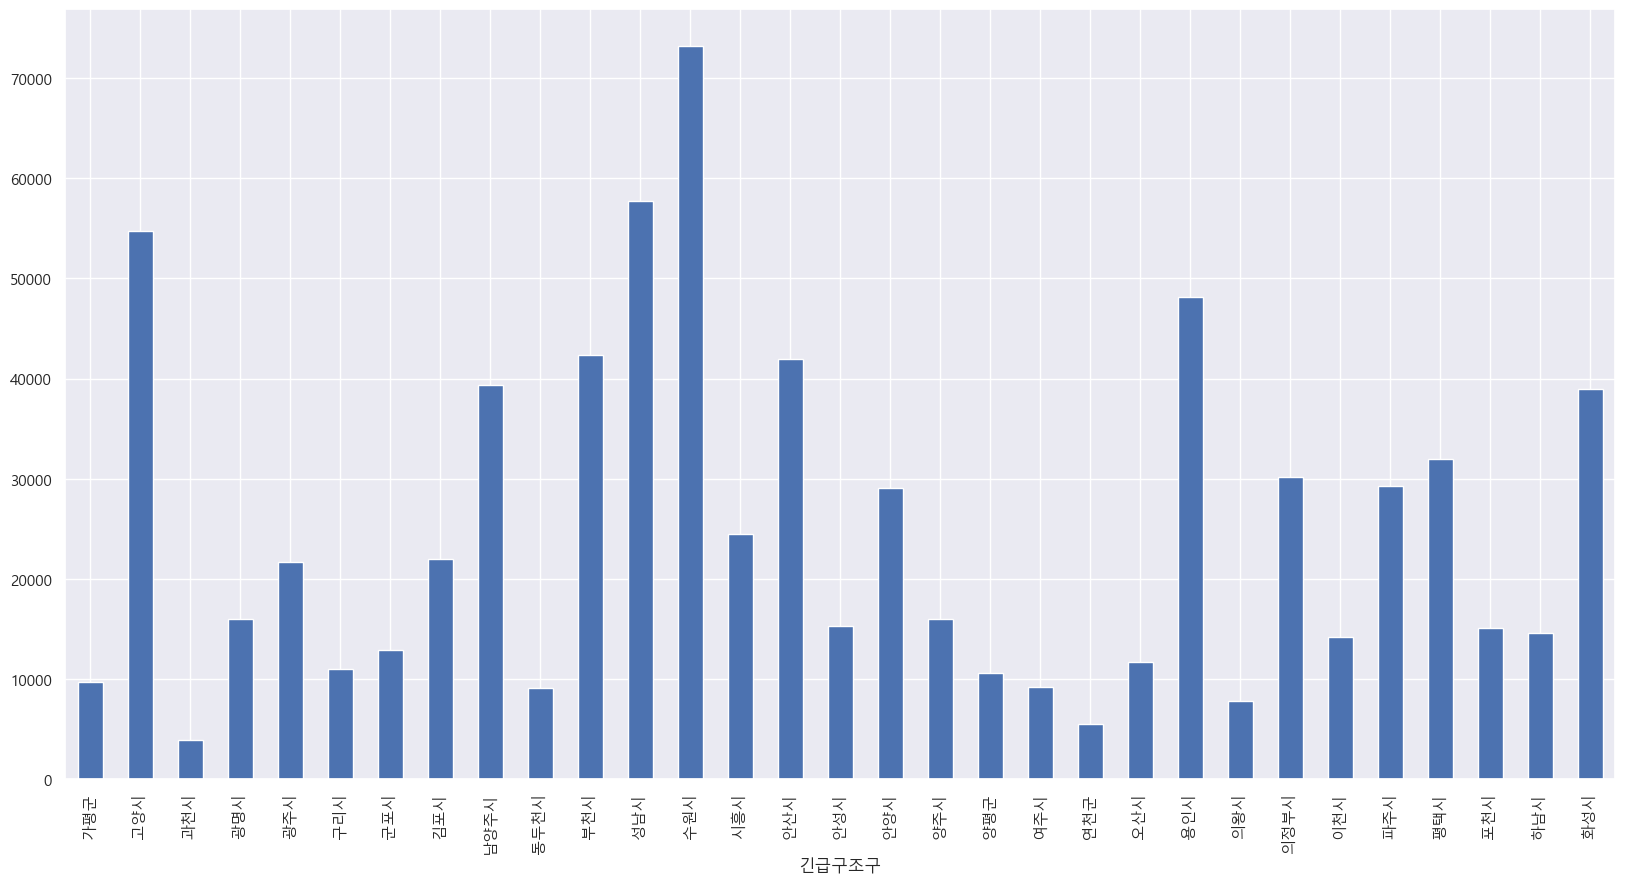

In [139]:
sns.set(rc={'figure.figsize':(20, 10)})
plt.rc('font',family='Malgun Gothic')
업무강도관련df.groupby('긴급구조구')['가중치'].sum().plot.bar()

In [148]:
지역별업무강도 = 업무강도관련df.groupby('긴급구조구')['가중치'].sum().reset_index()

In [152]:
지역별업무강도.columns = ['지역', '업무가중+출동건수']

In [141]:
지역별출동건수 = pd.read_csv('지역별출동건수.csv')

In [150]:
지역별출동건수

,지역,건수
0,수원시,51322
1,성남시,42876
2,고양시,41576
3,부천시,35474
4,용인시,35283
...,...,...
26,여주시,6629
27,가평군,6489
28,의왕시,5911
29,연천군,3792


In [200]:
main = pd.merge(지역별출동건수, 지역별업무강도, on='지역')

In [201]:
지역별총인구수 = pd.read_csv('지역별총인구수.csv').iloc[:,1:]

In [202]:
지역별대원수 = pd.read_csv('지역별대원수.csv')
지역별대원수.columns = ['지역', '정원(명)']

In [203]:
main = pd.merge(main, 지역별총인구수, on='지역')
main = pd.merge(main, 지역별대원수, on='지역')
main

,지역,건수,업무가중+출동건수,총인구수,정원(명)
0,수원시,51322,73219.7632,1242212.0,588
1,성남시,42876,57763.9648,972280.0,604
2,고양시,41576,54702.3840,1056853.0,625
3,부천시,35474,42370.8320,868106.0,424
4,용인시,35283,48129.4560,1053522.0,529
...,...,...,...,...,...
26,여주시,6629,9179.0544,115074.0,233
27,가평군,6489,9751.1296,63936.0,226
28,의왕시,5911,7824.7920,155084.0,185
29,연천군,3792,5555.1504,45606.0,232


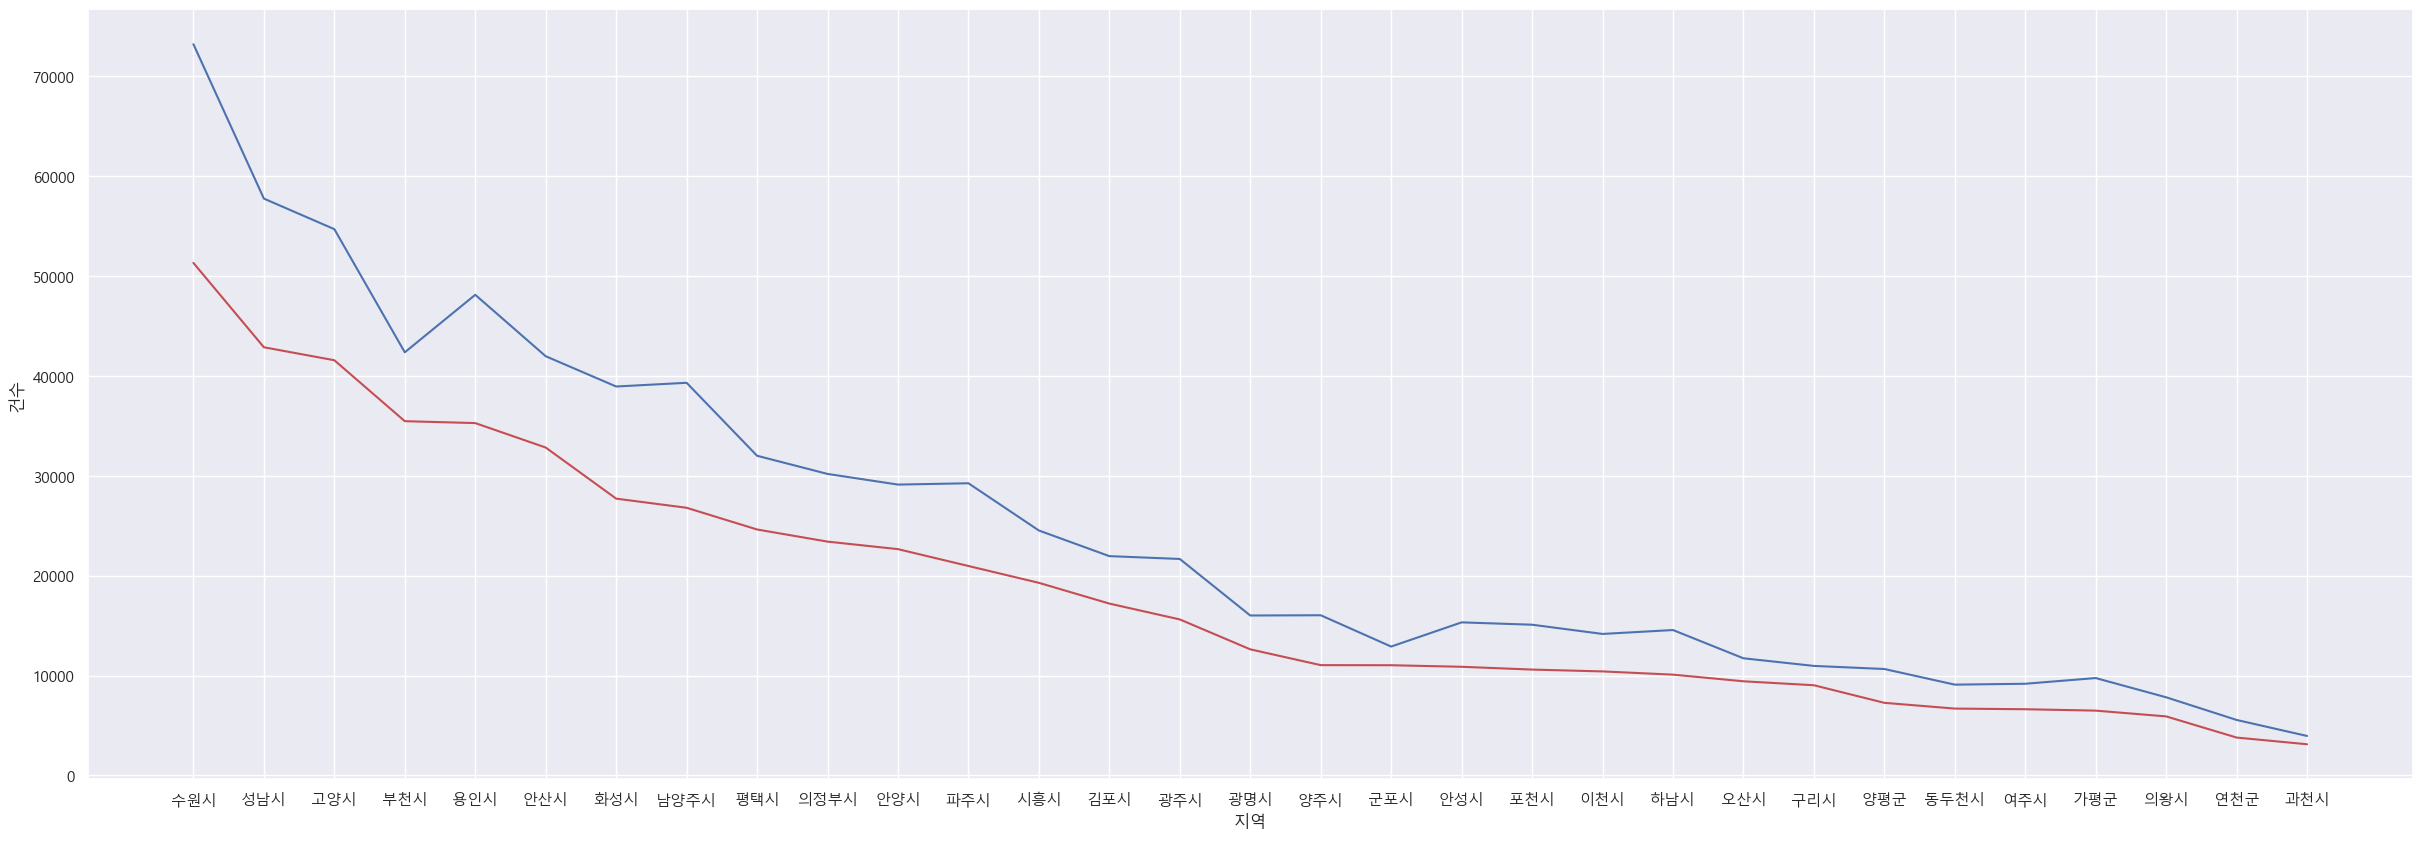

In [207]:
sns.set(rc={'figure.figsize':(30, 10)})
plt.rc('font', family='Malgun Gothic')

fig, ax1 = plt.subplots()

sns.lineplot(
    data=main, ax=ax1,
    x="지역", y="건수", color='r'
)
sns.lineplot(
    data=main, ax=ax1,
    x="지역", y="업무가중+출동건수"
)
plt.show()

In [191]:
업무지수총합 = main['업무가중+출동건수'].sum()
main['목표정원비율'] = main['업무가중+출동건수'] / 업무지수총합

정원총합 = main['정원(명)'].sum()
main['현재정원비율'] = main['정원(명)'] / 정원총합

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


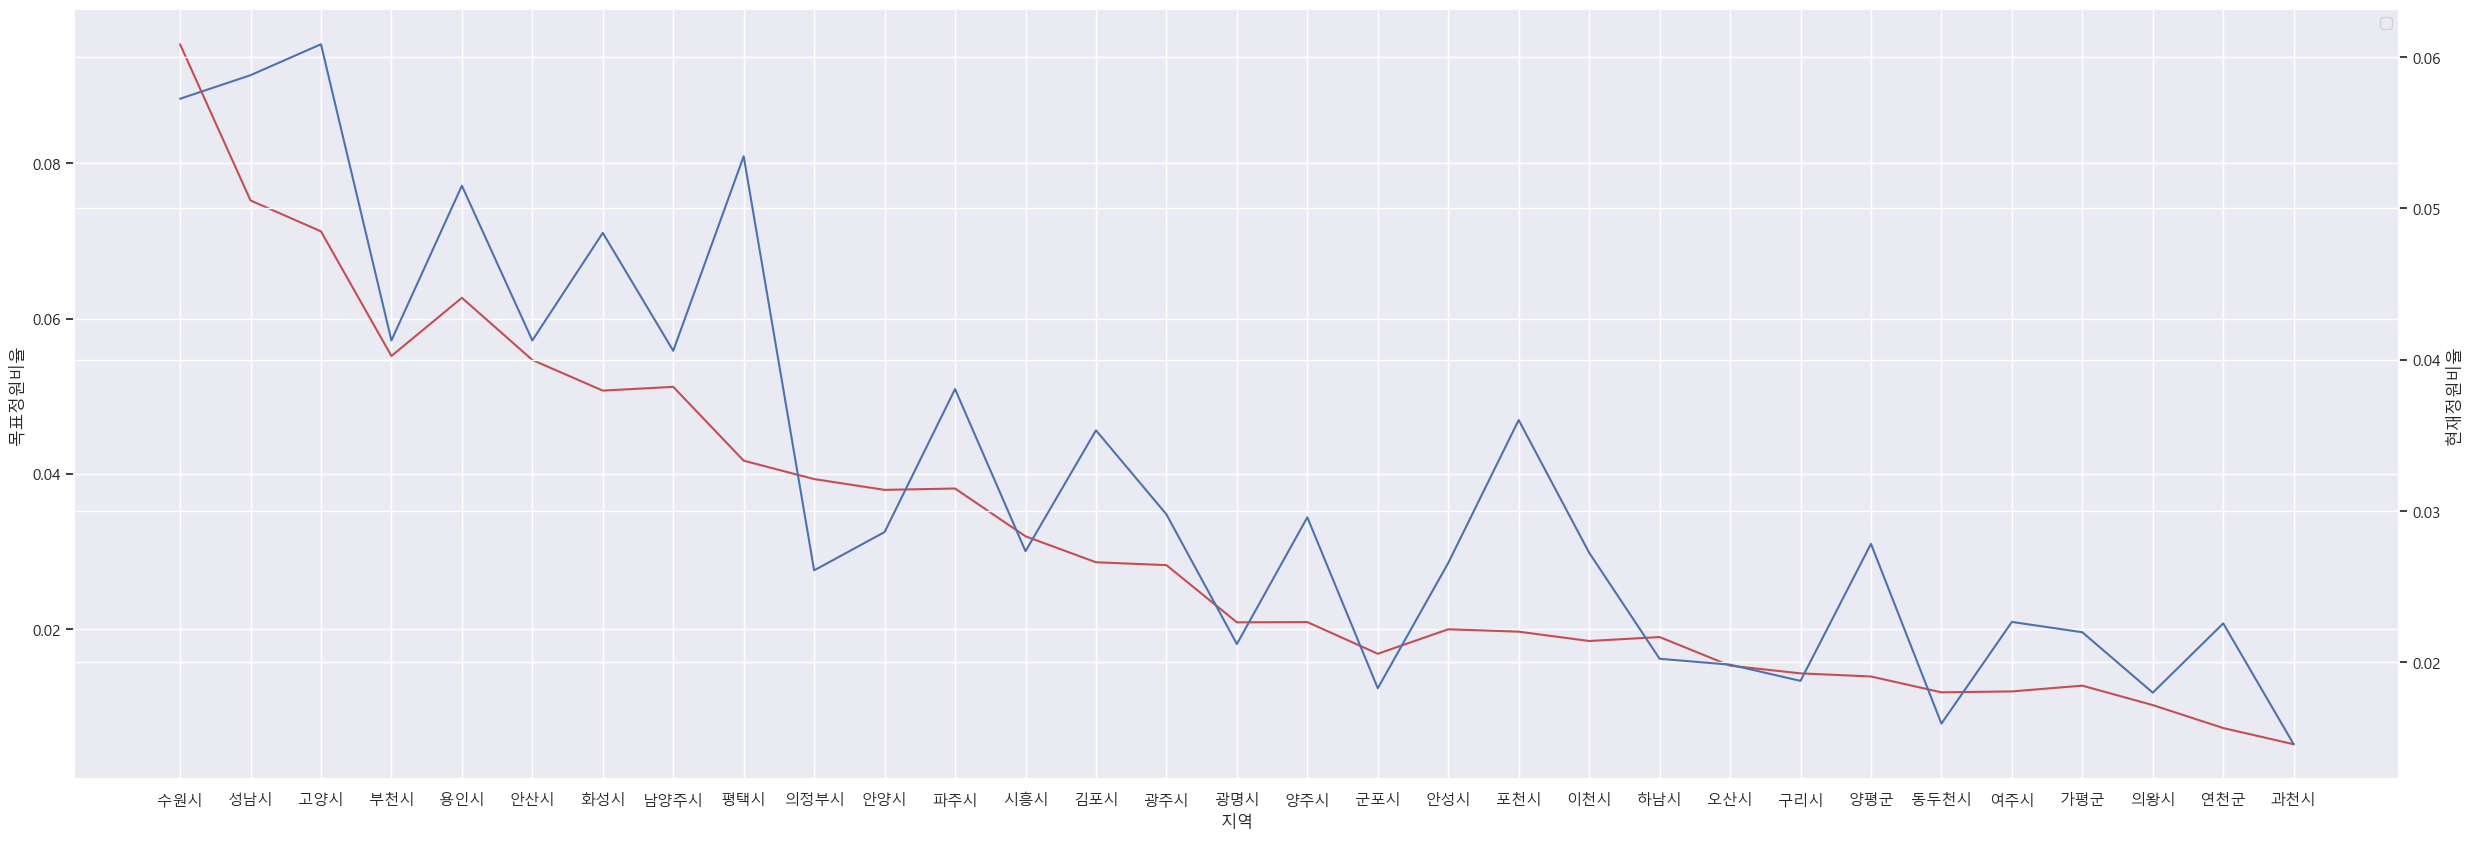

In [196]:
sns.set(rc={'figure.figsize':(30, 10)})
plt.rc('font', family='Malgun Gothic')

fig, ax1 = plt.subplots()

sns.lineplot(
    data=main, ax=ax1,
    x="지역", y="목표정원비율", color='r'
)

# ax2는 y2에 대한 그래프, twinx로 x축을 공유

ax2 = ax1.twinx()

sns.lineplot(
    data=main, ax=ax2,
    x="지역", y="현재정원비율"
)
plt.legend()
plt.show()

In [ ]:
pd.read_csv('')